In [8]:
import numpy as np
import pandas as pd
import cv2
from glob import glob
import os
from natsort import natsorted
import matplotlib.pyplot as plt
import fly_analysis as fa
from scipy.signal import savgol_filter
import tqdm
import re
from scipy.stats import circmean
import seaborn as sns
from scipy import stats

pattern = r".*?(\d+)_obj_id_(\d+)_cam_(\d+)_frame_(\d+)\.[^.]+$"

In [15]:
def find_value_position(arr, value):
    """
    Find between which two elements in a sorted array a value would fit.

    Parameters:
    arr (numpy.ndarray): Sorted array of values
    value (float/int): Value to locate

    Returns:
    tuple: (lower_idx, upper_idx, exact_match)
        - lower_idx: Index of the largest value less than the target
        - upper_idx: Index of the smallest value greater than the target
        - exact_match: Boolean indicating if the value exactly matches an array element

def process_video(video_path):
    # Open the video file
    cap = cv2.VideoCapture(str(video_path))
    
    # Get total number of frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Initialize numpy array with NaN values
    results = np.full((total_frames, 4), np.nan)
    # Fill the first column with frame numbers
    results[:, 0] = np.arange(total_frames)
    
    frame_number = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Apply threshold
        _, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)
        
        # Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            # Get the largest contour
            largest_contour = max(contours, key=cv2.contourArea)
            
            # Try to fit an ellipse
            if len(largest_contour) >= 5:  # Need at least 5 points to fit an ellipse
                ellipse = cv2.fitEllipse(largest_contour)
                
                # Extract information
                (x, y), (MA, ma), angle = ellipse
                
                # Update the corresponding row in results
                results[frame_number, 1:] = [x, y, angle]
        
        cv2.imshow('frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        frame_number += 1
    
    # Release the video capture object
    cap.release()
    
    # Convert results to a pandas DataFrame with headers
    df = pd.DataFrame(results, columns=['frame', 'x', 'y', 'orientation'])
    
    # Calculate velocities and heading
    df = calculate_velocities(df)

    # Handle edge cases
    if value < arr[0]:
        return -1, 0, False
    if value > arr[-1]:
        return len(arr) - 1, len(arr), False

    # Find exact match if it exists
    exact_match = np.where(arr == value)[0]
    if len(exact_match) > 0:
        idx = exact_match[0]
        return idx, idx, True

    # Find insertion point
    idx = np.searchsorted(arr, value)
    return idx - 1, idx, False

In [10]:
def interpolate_angle(angle1, angle2, ratio):
    """
    Interpolate between two angles using the shortest path around the circle.
    
    Parameters:
    angle1 (float): First angle in radians
    angle2 (float): Second angle in radians
    ratio (float): Interpolation ratio (0 to 1)
    
    Returns:
    float: Interpolated angle in radians
    """
    # Convert angles to be between -π and π
    angle1 = np.mod(angle1 + np.pi, 2 * np.pi) - np.pi
    angle2 = np.mod(angle2 + np.pi, 2 * np.pi) - np.pi
    
    # Calculate the difference between angles
    diff = angle2 - angle1
    
    # Ensure we're taking the shortest path around the circle
    if diff > np.pi:
        diff -= 2 * np.pi
    elif diff < -np.pi:
        diff += 2 * np.pi
    
    # Perform the interpolation
    result = angle1 + ratio * diff
    
    # Ensure result is between -π and π
    return np.mod(result + np.pi, 2 * np.pi) - np.pi

In [11]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import warnings
from scipy.signal import savgol_filter

def smooth_timeseries(data, window=5, polyorder=2):
    """
    Smooth timeseries data using Savitzky-Golay filter
    """
    if len(data) < window:
        return data
    return savgol_filter(data, window, polyorder)

def calculate_velocities(df, dt=0.002, smooth_window=5):
    """
    Calculate velocities and heading from position data
    
    Parameters:
    -----------
    df : pandas DataFrame
        Must contain 'x' and 'y' columns
    dt : float
        Time step between frames in seconds
    smooth_window : int
        Window size for position smoothing
    """
    # First smooth the position data
    df["x_smooth"] = smooth_timeseries(df["x"].values, window=smooth_window)
    df["y_smooth"] = smooth_timeseries(df["y"].values, window=smooth_window)
    
    # Calculate velocities using smoothed positions
    df["xvel"] = np.gradient(df["x_smooth"], dt)
    df["yvel"] = np.gradient(df["y_smooth"], dt)
    
    # Smooth velocities
    df["xvel"] = smooth_timeseries(df["xvel"].values, window=smooth_window)
    df["yvel"] = smooth_timeseries(df["yvel"].values, window=smooth_window)
    
    # Calculate speed and heading
    df["speed"] = np.sqrt(df["xvel"]**2 + df["yvel"]**2)
    df["heading"] = np.degrees(np.arctan2(df["yvel"], df["xvel"]))
    
    return df

def normalize_angle(angle, prev_angle=None):
    """
    Normalize angle to ensure consistent orientation between frames
    """
    if prev_angle is not None:
        # If the difference between angles is more than 90 degrees, flip it
        if abs(angle - prev_angle) > 90:
            angle = angle + 180 if angle < prev_angle else angle - 180
    return angle % 360

def process_video(video_path, min_area=50, max_area=1000, threshold_method="adaptive", save_video=False):
    """
    Process video file to track a black fly on white background
    
    Parameters:
    -----------
    video_path : str or Path
        Path to video file
    min_area : int
        Minimum contour area to consider
    max_area : int
        Maximum contour area to consider
    threshold_method : str
        'adaptive' or 'fixed'
    save_video : bool
        If True, saves a debug video with tracking visualization
    """
    video_path = Path(video_path)
    if not video_path.exists():
        raise FileNotFoundError(f"Video file not found: {video_path}")
    
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise ValueError(f"Error opening video file: {video_path}")
    
    # Get video properties
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Set up video writer if save_video is True
    if save_video:
        output_path = video_path.parent / f"{video_path.stem}_debug.mp4"
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(str(output_path), fourcc, fps, (frame_width, frame_height))
    
    # Initialize results array
    results = np.full((total_frames, 5), np.nan)
    results[:, 0] = np.arange(total_frames)
    
    frame_number = 0
    prev_angle = None
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
            
        try:
            # Create a copy for visualization if needed
            if save_video:
                debug_frame = frame.copy()
            
            # Convert to grayscale
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # Apply threshold
            if threshold_method == "adaptive":
                thresh = cv2.adaptiveThreshold(
                    gray, 
                    255, 
                    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                    cv2.THRESH_BINARY_INV, 
                    11, 
                    2
                )
            else:

                # Use fixed threshold to get only the darkest parts
                _, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)

                # Clean up noise and fill gaps
                kernel = np.ones((3,3), np.uint8)
                thresh = cv2.erode(thresh, kernel, iterations=1)
                thresh = cv2.dilate(thresh, kernel, iterations=1)

                # Keep only the largest component
                num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh)
                if num_labels > 1:  # if we found any components
                    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
                    thresh = np.uint8(labels == largest_label) * 255
            
            # Find contours
            contours, _ = cv2.findContours(
                thresh, 
                cv2.RETR_EXTERNAL, 
                cv2.CHAIN_APPROX_SIMPLE
            )
            
            # Filter contours by size
            valid_contours = [c for c in contours 
                            if min_area < cv2.contourArea(c) < max_area]
            
            if valid_contours:
                # Get the largest valid contour
                largest_contour = max(valid_contours, key=cv2.contourArea)
                contour_area = cv2.contourArea(largest_contour)
                
                # Fit ellipse if enough points
                if len(largest_contour) >= 5:
                    ellipse = cv2.fitEllipse(largest_contour)
                    (x, y), (MA, ma), angle = ellipse
                    
                    # Normalize angle
                    angle = normalize_angle(angle, prev_angle)
                    prev_angle = angle
                    
                    # Update results
                    results[frame_number, 1:] = [x, y, angle, contour_area]
                    
                    # Add visualization if saving video
                    if save_video:
                        # Draw the contour
                        cv2.drawContours(debug_frame, [largest_contour], -1, (0, 255, 0), 2)
                        
                        # Draw the ellipse
                        cv2.ellipse(debug_frame, ellipse, (255, 0, 0), 2)
                        
                        # Draw the orientation line
                        orientation_length = 20
                        end_x = int(x + orientation_length * np.cos(np.radians(angle)))
                        end_y = int(y + orientation_length * np.sin(np.radians(angle)))
                        cv2.line(debug_frame, (int(x), int(y)), (end_x, end_y), (0, 0, 255), 2)
                        
                        # Add text with tracking info
                        cv2.putText(debug_frame, f"Frame: {frame_number}", (10, 30), 
                                  cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                        cv2.putText(debug_frame, f"Area: {int(contour_area)}", (10, 60), 
                                  cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                        cv2.putText(debug_frame, f"Angle: {int(angle)}", (10, 90), 
                                  cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            # Write the debug frame if saving video
            if save_video:
                if len(valid_contours) == 0:
                    # Add text indicating no detection
                    cv2.putText(debug_frame, "No Detection", (10, 30), 
                              cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                out.write(debug_frame)
            
        except Exception as e:
            warnings.warn(f"Error processing frame {frame_number}: {str(e)}")
            if save_video:
                out.write(frame)  # Write original frame if error occurs
            
        frame_number += 1
    
    # Release video objects
    cap.release()
    if save_video:
        out.release()
    
    # Convert results to DataFrame and process as before
    df = pd.DataFrame(
        results, 
        columns=["frame", "x", "y", "orientation", "contour_area"]
    )
    
    df = calculate_velocities(df, dt=1/fps)
    
    df["tracking_quality"] = np.where(
        df["contour_area"].isna(), 
        0,
        np.where(
            (df["contour_area"] > min_area*1.5) & 
            (df["contour_area"] < max_area*0.8),
            2,
            1
        )
    )
    
    return df

def analyze_tracking_quality(df):
    """
    Analyze the quality of tracking results
    """
    total_frames = len(df)
    tracked_frames = df["x"].notna().sum()
    tracking_rate = tracked_frames / total_frames * 100
    
    quality_counts = df["tracking_quality"].value_counts()
    
    print("Tracking Summary:")
    print(f"Total frames: {total_frames}")
    print(f"Tracked frames: {tracked_frames} ({tracking_rate:.1f}%)")
    print("\nTracking quality distribution:")
    print("0: No detection")
    print("1: Borderline detection")
    print("2: Good detection")
    print(quality_counts)
    
    return tracking_rate, quality_counts

In [12]:

def sg_smooth(arr):
    return savgol_filter(arr, 51, 3)

In [13]:
stim = data[1]["stim"]

In [16]:
# Process video files
for video_path in video_files:
    df = process_video(video_path)

    # Save CSV file
    csv_filename = video_path.replace('.mp4', '.csv')
    df.to_csv(csv_filename, index=False, float_format='%.6f')
    break

: 

In [ ]:
data = fa.braidz.read_braidz(braidz_file)
stim = data[1]["stim"]

Reading /gpfs/soma_fs/nfc/nfc3008//Experiments/20230626_161309.braidz using pyarrow


In [8]:
from tqdm.contrib.concurrent import process_map

def process_single_video(video_path):
    # Process the video
    df = process_video(video_path, save_video=False, threshold_method="static")
    
    # Save CSV file
    csv_filename = video_path.replace(".mp4", ".csv")
    df.to_csv(csv_filename, index=False, float_format="%.6f")
    
    return df  # Optional - if you need the results

# Run parallel processing
results = process_map(process_single_video, video_files, max_workers=8)

  0%|          | 0/352 [00:00<?, ?it/s]

In [9]:
csv_files = natsorted(glob(os.path.join(videos_folder, "*.csv")))

In [22]:
# Initialize storage lists
stim_diff = []
heading_diff = []
stim_duration = []
stim_radius = []

stim_pos_pixels = []
stim_pos_heading = []
# Assuming these variables are defined in previous cells:
# csv_files: list of paths to CSV files
# pattern: regex pattern for file parsing
# stim: DataFrame with stimulus information
# stim2camera: DataFrame with camera calibration data
# sg_smooth: Savitzky-Golay smoothing function

# Process each CSV file
for csv_file in tqdm.tqdm(csv_files):
    # Load video tracking data
    video_df = pd.read_csv(csv_file)
    
    # Extract metadata from filename
    match = re.search(pattern, csv_file)
    prefix, obj_id, cam, frame = match.groups()
    
    # Get corresponding stimulus data
    stim_row = stim[(stim["obj_id"] == int(obj_id)) & (stim["frame"] == int(frame))]
    
    # Extract stimulus parameters
    stimulus_pos_x = stim_row["looming_pos_x"].values[0]
    stimulus_radius = stim_row["looming_radius"].values[0]
    stimulus_duration = stim_row["looming_duration"].values[0]
    
    # Get camera calibration data
    camera_calibration_df = stim2camera[stim2camera["camera"] == int(cam)]
    
    # Set up direction arrays
    stim_direction_in_pixel = np.append(
        camera_calibration_df["stim_direction"].values, 
        640  # Append image width for edge cases
    )
    stim_direction_in_heading = np.append(
        camera_calibration_df["heading_direction"].values,
        camera_calibration_df["heading_direction"].values[0]  # Wrap around
    )
    
    # Find position in calibration data
    pos1, pos2, exact = find_value_position(stim_direction_in_pixel, stimulus_pos_x)
    
    # Calculate stimulus heading
    if exact:
        stimulus_pos_heading = stim_direction_in_heading[pos1]
    else:
        # Calculate interpolation ratio
        ratio = (stimulus_pos_x - stim_direction_in_pixel[pos1]) / (
            stim_direction_in_pixel[pos2] - stim_direction_in_pixel[pos1]
        )
        
        # Interpolate heading direction
        stimulus_pos_heading = interpolate_angle(
            stim_direction_in_heading[pos1],
            stim_direction_in_heading[pos2],
            ratio
        )
    
    stim_pos_pixels.append(stimulus_pos_x)
    stim_pos_heading.append(stimulus_pos_heading)
    
    # Process trajectory data
    x = sg_smooth(video_df["x"].values)
    y = sg_smooth(video_df["y"].values)
    xvel = sg_smooth(video_df["xvel"].values)
    yvel = sg_smooth(video_df["yvel"].values)
    
    # Calculate heading angle
    theta = np.arctan2(yvel, xvel)
    
    # Extract and clean time windows
    before_range = np.arange(400, 650)
    after_range = np.arange(650, 700)
    theta_before = theta[before_range][~np.isnan(theta[before_range])]
    theta_after = theta[after_range][~np.isnan(theta[after_range])]
    # theta_before = theta[400:650][~np.isnan(theta[450:600])]
    # theta_after = theta[650:700][~np.isnan(theta[650:700])]
    
    # Calculate mean headings
    theta_before_mean = circmean(theta_before, high=np.pi, low=-np.pi)
    theta_after_mean = circmean(theta_after, high=np.pi, low=-np.pi)
    
    if np.isnan(theta_before_mean) or np.isnan(theta_after_mean):
        continue
    
    # Calculate angular differences
    # fly_stimulus_diff = np.mod(theta_before_mean - stimulus_pos_heading + np.pi, 2*np.pi) - np.pi
    # fly_fly_diff = np.mod(theta_before_mean - theta_after_mean + np.pi, 2*np.pi) - np.pi
    
    fly_stimulus_diff = np.arctan2(np.sin(stimulus_pos_heading - theta_before_mean), np.cos(stimulus_pos_heading - theta_before_mean))
    fly_fly_diff = np.arctan2(np.sin(theta_after_mean - theta_before_mean), np.cos(theta_after_mean - theta_before_mean))
    
    if np.isnan(fly_stimulus_diff):
        print(f"NaN value found in {csv_file}")
        
    # Store results
    stim_diff.append(fly_stimulus_diff)
    heading_diff.append(fly_fly_diff)
    stim_duration.append(stimulus_duration)
    stim_radius.append(stimulus_radius)

# Create output DataFrame
results_df = pd.DataFrame({
    "stim_diff": stim_diff,
    "heading_diff": heading_diff,
    "stim_duration": stim_duration,
    "stim_radius": stim_radius,
})

# Display first few rows of results
results_df.head()

  0%|          | 0/352 [00:00<?, ?it/s]

100%|██████████| 352/352 [00:02<00:00, 154.40it/s]


,stim_diff,heading_diff,stim_duration,stim_radius
0,2.003322,1.501596,300,32
1,1.676844,1.226050,300,32
2,-2.338252,0.135662,300,32
3,-2.596106,0.221226,300,32
4,-2.730981,-0.192409,300,32


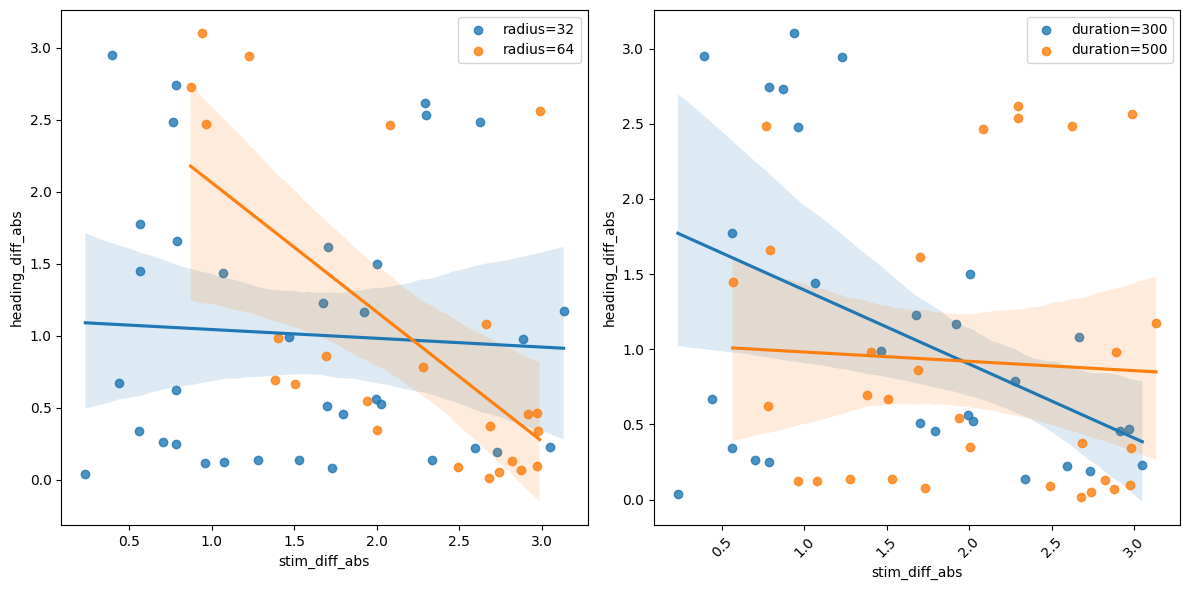

In [40]:
results_df["stim_diff_binned"] = pd.cut(
    np.abs(results_df["stim_diff"]), 
    bins=np.linspace(0, np.pi, 6), 
)

results_df["stim_diff_abs"] = np.abs(results_df["stim_diff"])
results_df["heading_diff_abs"] = np.abs(results_df["heading_diff"])

fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

# Use regplot for the first subplot
for radius in results_df["stim_radius"].unique():
    mask = results_df["stim_radius"] == radius
    sns.regplot(
        x="stim_diff_abs",
        y="heading_diff_abs",
        data=results_df[mask],
        ax=axs[0],
        label=f"radius={radius}"
    )
axs[0].legend()

# Use regplot for the second subplot
for duration in results_df["stim_duration"].unique():
    mask = results_df["stim_duration"] == duration
    sns.regplot(
        x="stim_diff_abs",
        y="heading_diff_abs",
        data=results_df[mask],
        ax=axs[1],
        label=f"duration={duration}"
    )
axs[1].legend()
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Overall correlation: r=-0.269, p=-0.269

Correlations by radius:
Radius 32: r=-0.057, p=0.743
Radius 64: r=-0.637, p=0.001

Correlations by duration:
Duration 300: r=-0.434, p=0.019
Duration 500: r=-0.054, p=0.775

ANOVA results for radius interaction:
                                 sum_sq    df         F    PR(>F)
C(stim_radius)                 0.621709   1.0  0.799161  0.375170
stim_diff_abs                  4.514315   1.0  5.802824  0.019315
C(stim_radius):stim_diff_abs   5.896791   1.0  7.579896  0.007942
Residual                      43.565281  56.0       NaN       NaN

ANOVA results for duration interaction:
                                   sum_sq    df         F    PR(>F)
C(stim_duration)                 0.070450   1.0  0.081958  0.775717
stim_diff_abs                    3.416481   1.0  3.974604  0.051071
C(stim_duration):stim_diff_abs   1.876979   1.0  2.183606  0.145090
Residual                        48.136352  56.0       NaN       NaN


{'overall_correlation': PearsonRResult(statistic=np.float64(-0.26854919851214437), pvalue=np.float64(0.03801494125099603)),
 'radius_correlations': [{'radius': np.int64(32),
   'correlation': np.float64(-0.056596396574068245),
   'p_value': np.float64(0.7430197838277883)},
  {'radius': np.int64(64),
   'correlation': np.float64(-0.6371791047250526),
   'p_value': np.float64(0.0008122588356186166)}],
 'duration_correlations': [{'duration': np.int64(300),
   'correlation': np.float64(-0.43370985235540305),
   'p_value': np.float64(0.018747173466205254)},
  {'duration': np.int64(500),
   'correlation': np.float64(-0.05352039155052997),
   'p_value': np.float64(0.7749177856959366)}],
 'radius_anova':                                  sum_sq    df         F    PR(>F)
 C(stim_radius)                 0.621709   1.0  0.799161  0.375170
 stim_diff_abs                  4.514315   1.0  5.802824  0.019315
 C(stim_radius):stim_diff_abs   5.896791   1.0  7.579896  0.007942
 Residual                  

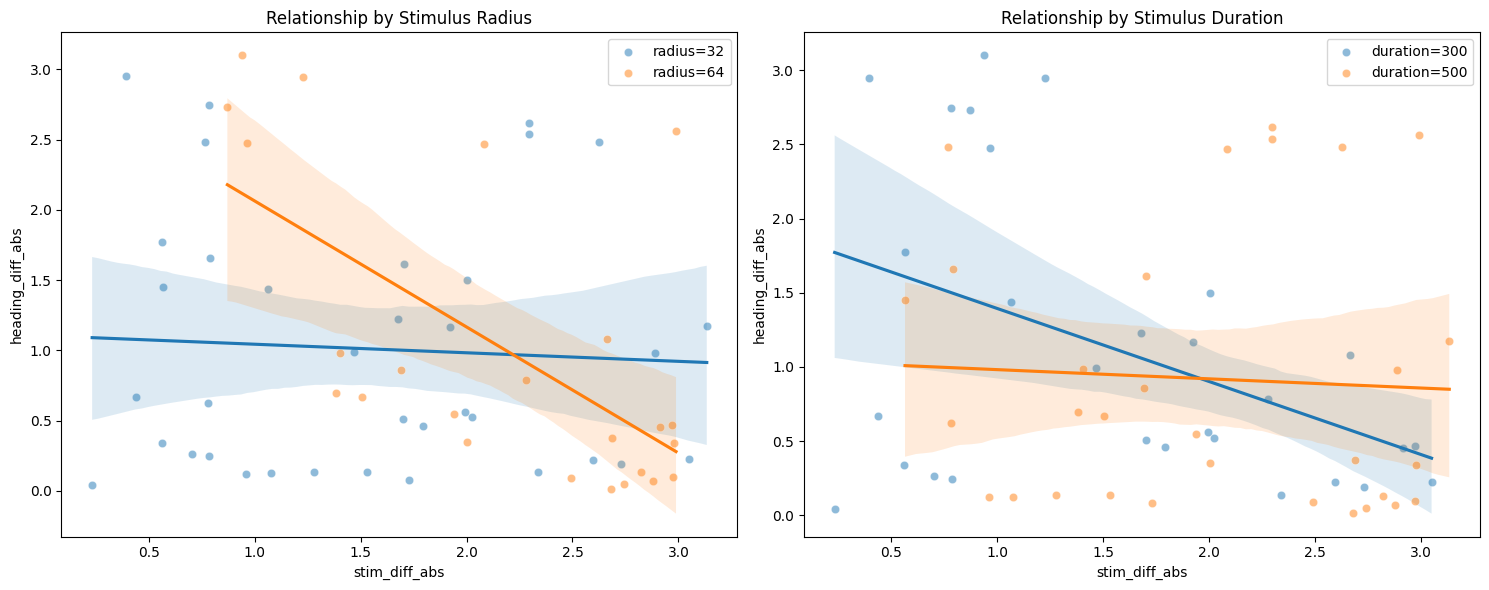

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

def analyze_relationships(df):
    # 1. Overall correlation
    overall_corr = stats.pearsonr(
        df['stim_diff_abs'], 
        df['heading_diff_abs']
    )
    print(f"Overall correlation: r={overall_corr[0]:.3f}, p={overall_corr[0]:.3f}")
    
    # 2. Correlation by radius
    print("\nCorrelations by radius:")
    radius_correlations = []
    for radius in df['stim_radius'].unique():
        mask = df['stim_radius'] == radius
        corr = stats.pearsonr(
            df.loc[mask, 'stim_diff_abs'],
            df.loc[mask, 'heading_diff_abs']
        )
        radius_correlations.append({
            'radius': radius,
            'correlation': corr[0],
            'p_value': corr[1]
        })
        print(f"Radius {radius}: r={corr[0]:.3f}, p={corr[1]:.3f}")
    
    # 3. Correlation by duration
    print("\nCorrelations by duration:")
    duration_correlations = []
    for duration in df['stim_duration'].unique():
        mask = df['stim_duration'] == duration
        corr = stats.pearsonr(
            df.loc[mask, 'stim_diff_abs'],
            df.loc[mask, 'heading_diff_abs']
        )
        duration_correlations.append({
            'duration': duration,
            'correlation': corr[0],
            'p_value': corr[1]
        })
        print(f"Duration {duration}: r={corr[0]:.3f}, p={corr[1]:.3f}")
    
    # 4. ANOVA to test for interaction effects
    model = ols('heading_diff_abs ~ C(stim_radius) * stim_diff_abs', data=df).fit()
    radius_interaction = anova_lm(model, typ=2)
    print("\nANOVA results for radius interaction:")
    print(radius_interaction)
    
    model = ols('heading_diff_abs ~ C(stim_duration) * stim_diff_abs', data=df).fit()
    duration_interaction = anova_lm(model, typ=2)
    print("\nANOVA results for duration interaction:")
    print(duration_interaction)
    
    # 5. Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Define color palettes
    radius_colors = {'32': '#1f77b4', '64': '#ff7f0e'}  # Blue and orange
    duration_colors = {'300': '#1f77b4', '500': '#ff7f0e'}

    # Plot by radius
    for radius in df['stim_radius'].unique():
        mask = df['stim_radius'] == radius
        color = radius_colors[str(int(radius))]
        
        # Scatter plot
        sns.scatterplot(
            data=df[mask],
            x='stim_diff_abs',
            y='heading_diff_abs',
            color=color,
            alpha=0.5,
            ax=ax1,
            label=f'radius={radius}'
        )
        
        # Regression line
        sns.regplot(
            data=df[mask],
            x='stim_diff_abs',
            y='heading_diff_abs',
            scatter=False,
            color=color,
            ax=ax1,
        )
    ax1.set_title('Relationship by Stimulus Radius')

    # Plot by duration
    for duration in df['stim_duration'].unique():
        mask = df['stim_duration'] == duration
        color = duration_colors[str(int(duration))]
        
        # Scatter plot
        sns.scatterplot(
            data=df[mask],
            x='stim_diff_abs',
            y='heading_diff_abs',
            color=color,
            alpha=0.5,
            ax=ax2,
            label=f'duration={duration}'
        )
        
        # Regression line
        sns.regplot(
            data=df[mask],
            x='stim_diff_abs',
            y='heading_diff_abs',
            scatter=False,
            color=color,
            ax=ax2,
        )
    ax2.set_title('Relationship by Stimulus Duration')

    plt.tight_layout()
    return {
        'overall_correlation': overall_corr,
        'radius_correlations': radius_correlations,
        'duration_correlations': duration_correlations,
        'radius_anova': radius_interaction,
        'duration_anova': duration_interaction
    }

analyze_relationships(results_df)

2024-12-04 10:50:10,385 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-12-04 10:50:10,391 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-12-04 10:50:10,422 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-12-04 10:50:10,428 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Radius Comparison (32 vs 64):
t-statistic = -0.011
p-value = 0.991

Means:
                 mean       std
stim_radius                    
32           1.011447  0.903302
64           1.014171  1.051251

Duration Comparison (300 vs 500):
t-statistic = 0.770
p-value = 0.444

Means:
                   mean       std
stim_duration                    
300            1.111227  0.995527
500            0.920214  0.925198


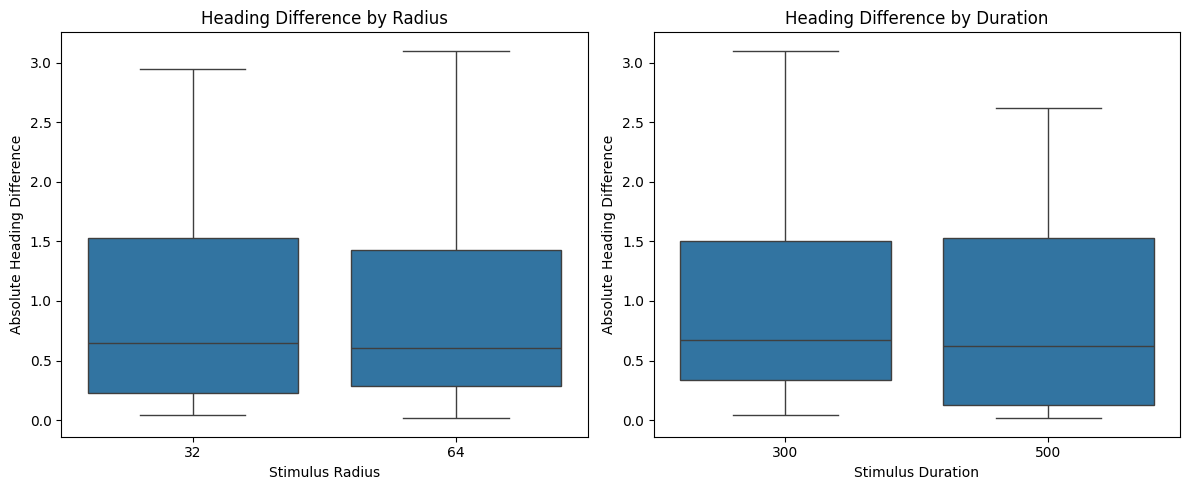

In [45]:
# Statistical tests
radius_ttest = stats.ttest_ind(
    results_df[results_df['stim_radius'] == 32]['heading_diff_abs'],
    results_df[results_df['stim_radius'] == 64]['heading_diff_abs']
)

duration_ttest = stats.ttest_ind(
    results_df[results_df['stim_duration'] == 300]['heading_diff_abs'],
    results_df[results_df['stim_duration'] == 500]['heading_diff_abs']
)

# Calculate means for effect sizes
radius_means = results_df.groupby('stim_radius')['heading_diff_abs'].agg(['mean', 'std'])
duration_means = results_df.groupby('stim_duration')['heading_diff_abs'].agg(['mean', 'std'])

# Print results
print("Radius Comparison (32 vs 64):")
print(f"t-statistic = {radius_ttest.statistic:.3f}")
print(f"p-value = {radius_ttest.pvalue:.3f}")
print("\nMeans:")
print(radius_means)

print("\nDuration Comparison (300 vs 500):")
print(f"t-statistic = {duration_ttest.statistic:.3f}")
print(f"p-value = {duration_ttest.pvalue:.3f}")
print("\nMeans:")
print(duration_means)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Box plots
sns.boxplot(x='stim_radius', y='heading_diff_abs', data=results_df, ax=ax1)
ax1.set_title('Heading Difference by Radius')
ax1.set_xlabel('Stimulus Radius')
ax1.set_ylabel('Absolute Heading Difference')

sns.boxplot(x='stim_duration', y='heading_diff_abs', data=results_df, ax=ax2)
ax2.set_title('Heading Difference by Duration')
ax2.set_xlabel('Stimulus Duration')
ax2.set_ylabel('Absolute Heading Difference')

plt.tight_layout()
plt.show()

Full Model ANOVA:
                                                  sum_sq    df          F  \
C(stim_radius)                                  0.397767   1.0   0.602814   
C(stim_duration)                                0.019754   1.0   0.029938   
C(stim_radius):C(stim_duration)                 6.651078   1.0  10.079675   
stim_diff_abs                                   3.166544   1.0   4.798881   
C(stim_radius):stim_diff_abs                    3.978907   1.0   6.030014   
C(stim_duration):stim_diff_abs                  5.223481   1.0   7.916159   
C(stim_radius):C(stim_duration):stim_diff_abs   0.123744   1.0   0.187534   
Residual                                       34.312223  52.0        NaN   

                                                 PR(>F)  
C(stim_radius)                                 0.441024  
C(stim_duration)                               0.863303  
C(stim_radius):C(stim_duration)                0.002520  
stim_diff_abs                                  0.032984 

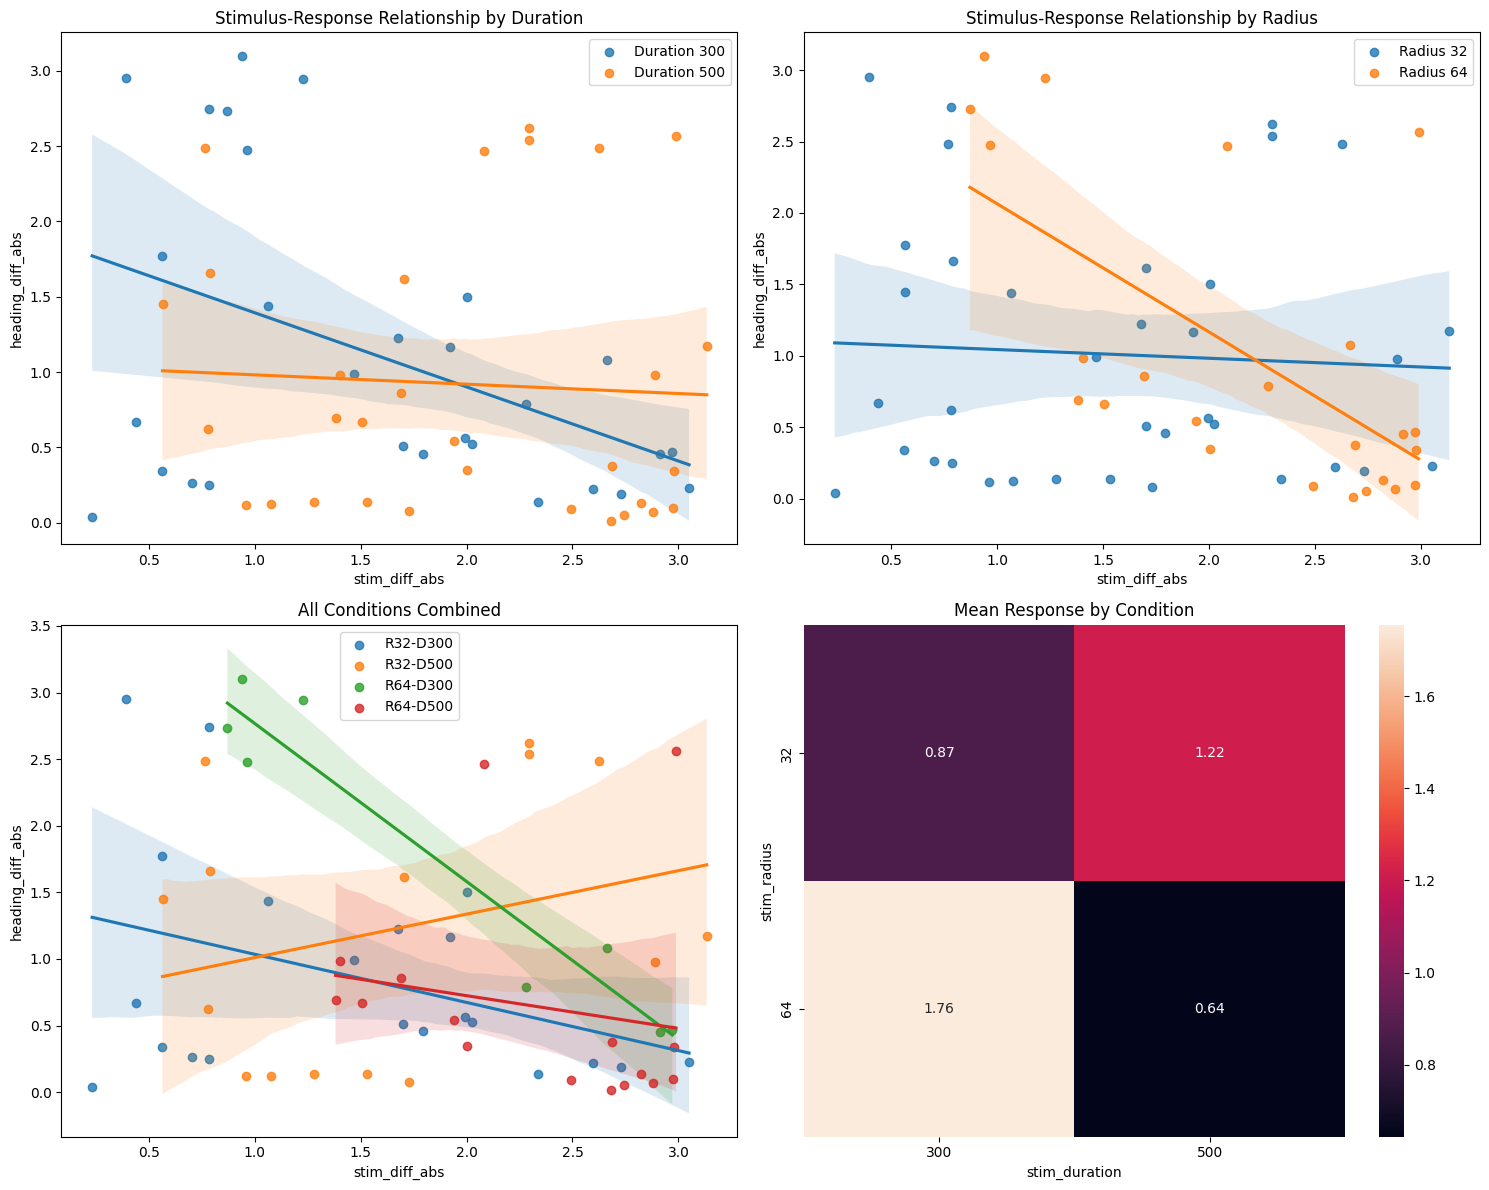


Pairwise Comparisons:

Radius 32, Duration 300:
Slope: -0.362
R-squared: 0.138
P-value: 0.097

Radius 32, Duration 500:
Slope: 0.326
R-squared: 0.077
P-value: 0.317

Radius 64, Duration 300:
Slope: -1.187
R-squared: 0.924
P-value: 0.000

Radius 64, Duration 500:
Slope: -0.246
R-squared: 0.035
P-value: 0.488


In [46]:
# 1. Create interaction terms and fit a comprehensive linear model
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Full model with all interactions
model = ols('heading_diff_abs ~ C(stim_radius) * C(stim_duration) * stim_diff_abs', 
            data=results_df).fit()
print("Full Model ANOVA:")
print(sm.stats.anova_lm(model, typ=2))

# 2. Visualize interactions with faceted plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot radius effects for each duration
for duration in results_df['stim_duration'].unique():
    mask = results_df['stim_duration'] == duration
    sns.regplot(
        data=results_df[mask],
        x='stim_diff_abs',
        y='heading_diff_abs',
        label=f'Duration {duration}',
        scatter=True,
        ax=ax1
    )
ax1.set_title('Stimulus-Response Relationship by Duration')
ax1.legend()

# Plot duration effects for each radius
for radius in results_df['stim_radius'].unique():
    mask = results_df['stim_radius'] == radius
    sns.regplot(
        data=results_df[mask],
        x='stim_diff_abs',
        y='heading_diff_abs',
        label=f'Radius {radius}',
        scatter=True,
        ax=ax2
    )
ax2.set_title('Stimulus-Response Relationship by Radius')
ax2.legend()

# Combined conditions plot
conditions = []
for radius in results_df['stim_radius'].unique():
    for duration in results_df['stim_duration'].unique():
        mask = (results_df['stim_radius'] == radius) & (results_df['stim_duration'] == duration)
        sns.regplot(
            data=results_df[mask],
            x='stim_diff_abs',
            y='heading_diff_abs',
            label=f'R{radius}-D{duration}',
            scatter=True,
            ax=ax3
        )
ax3.set_title('All Conditions Combined')
ax3.legend()

# Interaction heatmap
grouped_means = results_df.groupby(['stim_radius', 'stim_duration'])['heading_diff_abs'].mean().unstack()
sns.heatmap(grouped_means, annot=True, fmt='.2f', ax=ax4)
ax4.set_title('Mean Response by Condition')

plt.tight_layout()
plt.show()

# 3. Pairwise comparisons for specific conditions
from scipy import stats

print("\nPairwise Comparisons:")
for radius in results_df['stim_radius'].unique():
    for duration in results_df['stim_duration'].unique():
        condition = (results_df['stim_radius'] == radius) & \
                   (results_df['stim_duration'] == duration)
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            results_df[condition]['stim_diff_abs'],
            results_df[condition]['heading_diff_abs']
        )
        print(f"\nRadius {radius}, Duration {duration}:")
        print(f"Slope: {slope:.3f}")
        print(f"R-squared: {r_value**2:.3f}")
        print(f"P-value: {p_value:.3f}")

/tmp/ipykernel_104427/2910380821.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  radius_var = results_df.groupby('stim_radius').apply(compute_variability_metrics)
/tmp/ipykernel_104427/2910380821.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  duration_var = results_df.groupby('stim_duration').apply(compute_variability_metrics)
/tmp/ipykernel_104427/2910380821.py:24: DeprecationWarning: DataFrameG

Variability by Radius:
                  std        cv       iqr     n
stim_radius                                    
32           0.903302  0.893079  1.304428  36.0
64           1.051251  1.036562  1.136796  24.0

Variability by Duration:
                    std        cv       iqr     n
stim_duration                                    
300            0.995527  0.895881  1.161216  29.0
500            0.925198  1.005417  1.403758  31.0

Variability by Combined Conditions:
                                std        cv       iqr     n
stim_radius stim_duration                                    
32          300            0.828337  0.956583  0.978851  21.0
            500            0.991693  0.816096  1.934998  15.0
64          300            1.161702  0.661892  2.077948   8.0
            500            0.790907  1.228699  0.640102  16.0


/tmp/ipykernel_104427/2910380821.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  var_by_stim = results_df.groupby(['stim_diff_binned', 'stim_radius'])['heading_diff_abs'].std().unstack()
/tmp/ipykernel_104427/2910380821.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  var_by_stim_dur = results_df.groupby(['stim_diff_binned', 'stim_duration'])['heading_diff_abs'].std().unstack()
2024-12-04 10:54:23,669 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-

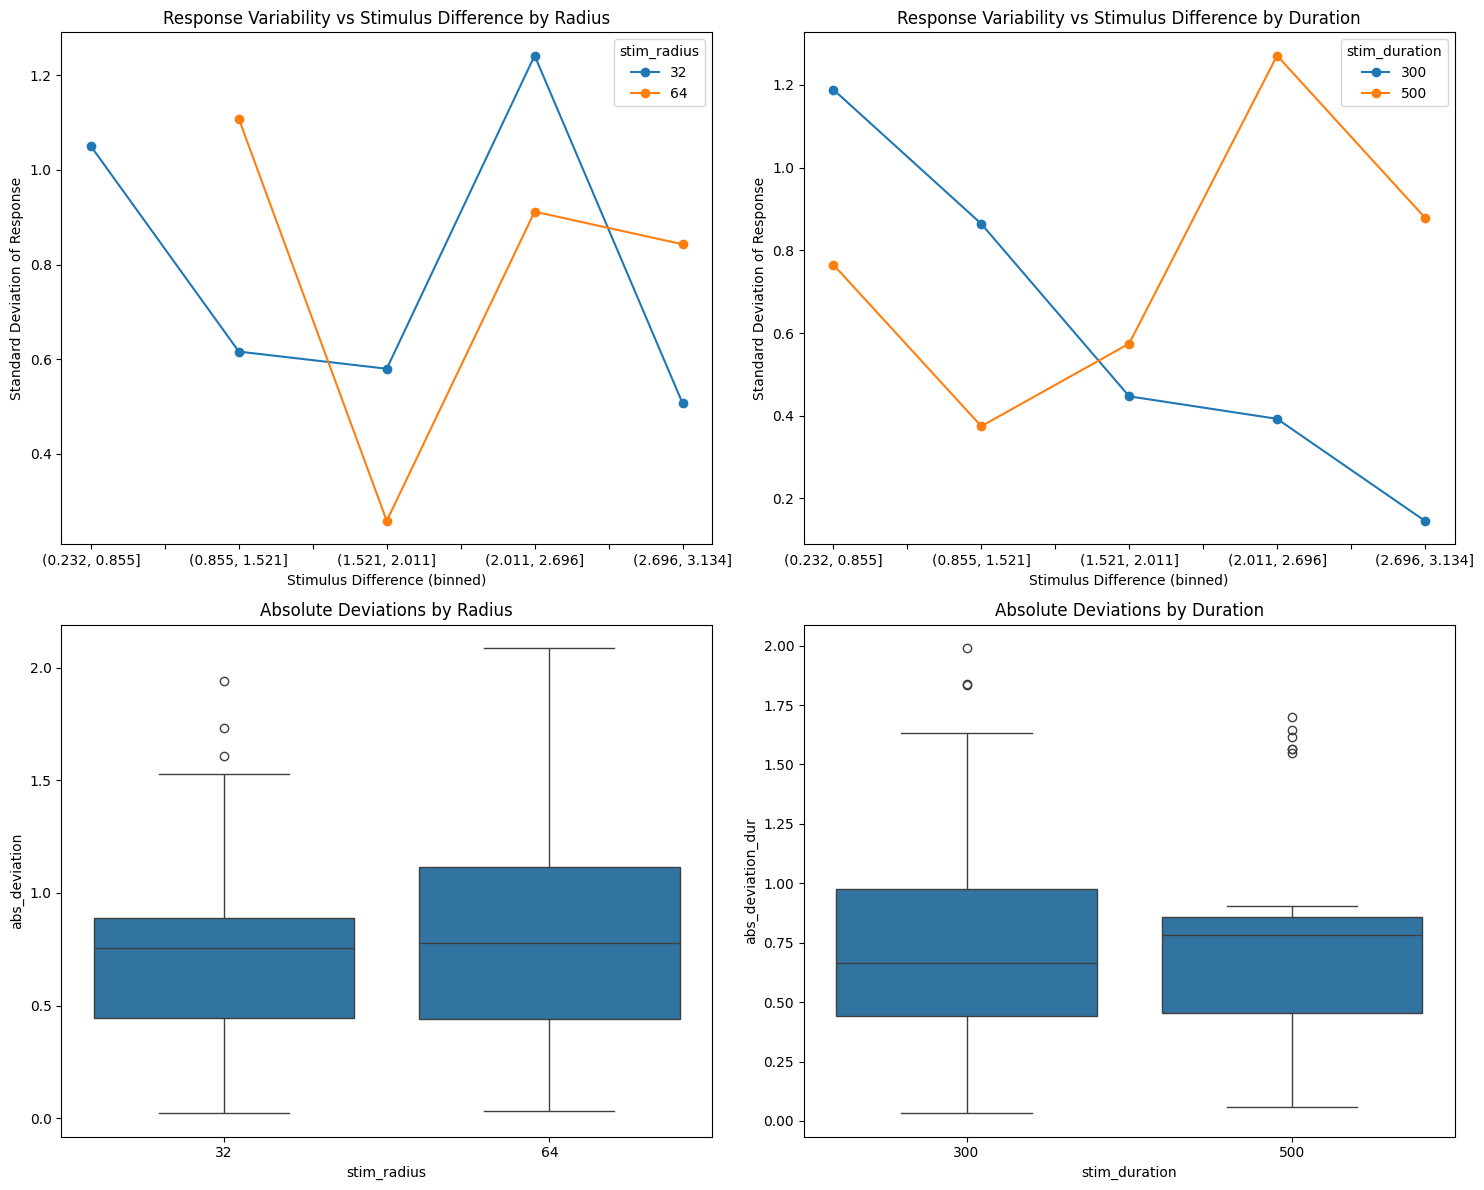


Levene's Test for Equal Variances:
Radius comparison: statistic=0.023, p=0.879
Duration comparison: statistic=0.048, p=0.827


In [47]:
# 1. Calculate variability metrics for each condition
from scipy import stats

# Compute standard deviation and coefficient of variation for each condition
def compute_variability_metrics(group):
    return pd.Series({
        'std': group['heading_diff_abs'].std(),
        'cv': group['heading_diff_abs'].std() / group['heading_diff_abs'].mean(),
        'iqr': group['heading_diff_abs'].quantile(0.75) - group['heading_diff_abs'].quantile(0.25),
        'n': len(group)
    })

# By radius
radius_var = results_df.groupby('stim_radius').apply(compute_variability_metrics)
print("Variability by Radius:")
print(radius_var)

# By duration
duration_var = results_df.groupby('stim_duration').apply(compute_variability_metrics)
print("\nVariability by Duration:")
print(duration_var)

# By combined conditions
combined_var = results_df.groupby(['stim_radius', 'stim_duration']).apply(compute_variability_metrics)
print("\nVariability by Combined Conditions:")
print(combined_var)

# 2. Visualize variability patterns
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot variance vs stimulus difference for each radius
results_df['stim_diff_binned'] = pd.qcut(results_df['stim_diff_abs'], 5)
var_by_stim = results_df.groupby(['stim_diff_binned', 'stim_radius'])['heading_diff_abs'].std().unstack()

var_by_stim.plot(marker='o', ax=ax1)
ax1.set_title('Response Variability vs Stimulus Difference by Radius')
ax1.set_xlabel('Stimulus Difference (binned)')
ax1.set_ylabel('Standard Deviation of Response')

# Plot variance vs stimulus difference for each duration
var_by_stim_dur = results_df.groupby(['stim_diff_binned', 'stim_duration'])['heading_diff_abs'].std().unstack()
var_by_stim_dur.plot(marker='o', ax=ax2)
ax2.set_title('Response Variability vs Stimulus Difference by Duration')
ax2.set_xlabel('Stimulus Difference (binned)')
ax2.set_ylabel('Standard Deviation of Response')

# Boxplot of absolute deviations from mean
results_df['abs_deviation'] = abs(results_df['heading_diff_abs'] - 
                                results_df.groupby('stim_radius')['heading_diff_abs'].transform('mean'))
sns.boxplot(x='stim_radius', y='abs_deviation', data=results_df, ax=ax3)
ax3.set_title('Absolute Deviations by Radius')

results_df['abs_deviation_dur'] = abs(results_df['heading_diff_abs'] - 
                                    results_df.groupby('stim_duration')['heading_diff_abs'].transform('mean'))
sns.boxplot(x='stim_duration', y='abs_deviation_dur', data=results_df, ax=ax4)
ax4.set_title('Absolute Deviations by Duration')

plt.tight_layout()
plt.show()

# 3. Levene's test for equality of variances
radius_levene = stats.levene(
    results_df[results_df['stim_radius'] == 32]['heading_diff_abs'],
    results_df[results_df['stim_radius'] == 64]['heading_diff_abs']
)

duration_levene = stats.levene(
    results_df[results_df['stim_duration'] == 300]['heading_diff_abs'],
    results_df[results_df['stim_duration'] == 500]['heading_diff_abs']
)

print("\nLevene's Test for Equal Variances:")
print(f"Radius comparison: statistic={radius_levene.statistic:.3f}, p={radius_levene.pvalue:.3f}")
print(f"Duration comparison: statistic={duration_levene.statistic:.3f}, p={duration_levene.pvalue:.3f}")

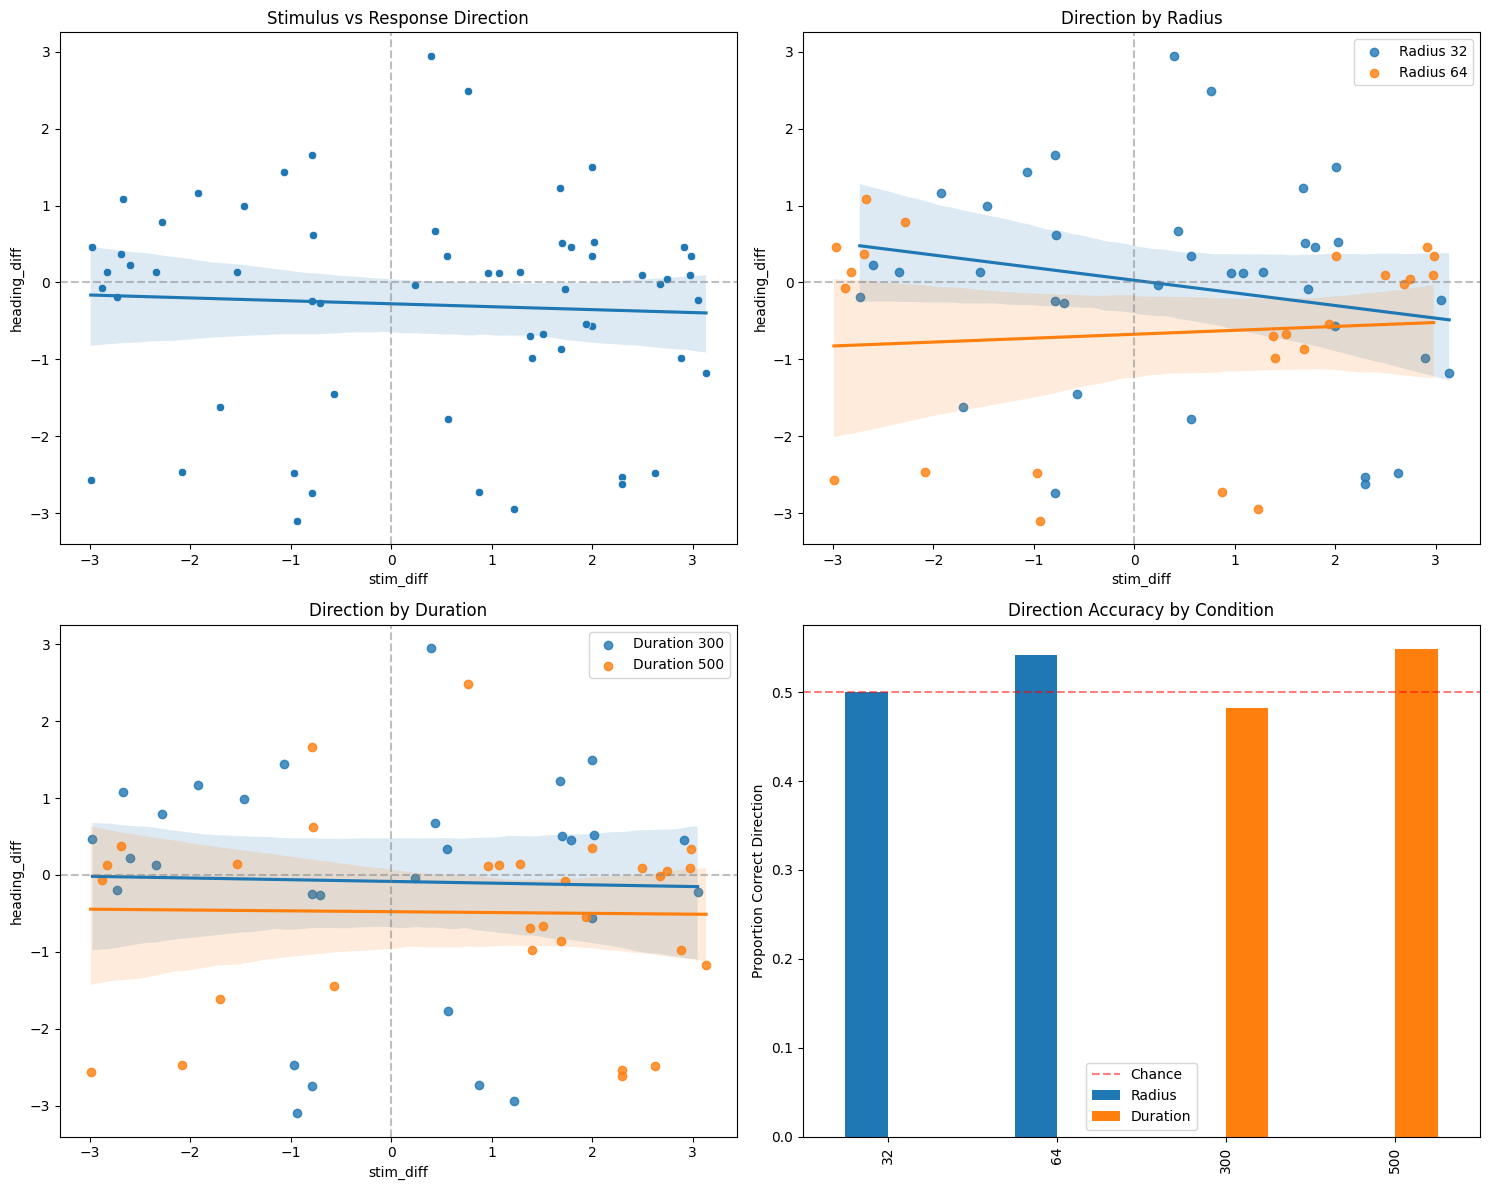


Directional Accuracy:
Overall accuracy: 0.517
Binomial test p-value: 0.897

By Radius:
stim_radius
32    0.500000
64    0.541667
Name: correct_direction, dtype: float64

By Duration:
stim_duration
300    0.482759
500    0.548387
Name: correct_direction, dtype: float64


In [49]:
# 1. Create directional accuracy metric
# Correct response is when signs are opposite (negative stim -> positive heading and vice versa)
results_df['correct_direction'] = np.sign(results_df['stim_diff']) * np.sign(results_df['heading_diff']) == -1

# Calculate accuracy by condition
radius_accuracy = results_df.groupby('stim_radius')['correct_direction'].mean()
duration_accuracy = results_df.groupby('stim_duration')['correct_direction'].mean()

# Statistical test (binomial test against chance 0.5)
from scipy.stats import binomtest

overall_accuracy = binomtest(
    k=results_df['correct_direction'].sum(),
    n=len(results_df),
    p=0.5
)

# 2. Visualize directional relationships
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Overall relationship
sns.scatterplot(
    data=results_df,
    x='stim_diff',
    y='heading_diff',
    ax=ax1
)
sns.regplot(
    data=results_df,
    x='stim_diff',
    y='heading_diff',
    scatter=False,
    ax=ax1
)
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax1.set_title('Stimulus vs Response Direction')

# By radius
for radius in results_df['stim_radius'].unique():
    mask = results_df['stim_radius'] == radius
    sns.regplot(
        data=results_df[mask],
        x='stim_diff',
        y='heading_diff',
        label=f'Radius {radius}',
        scatter=True,
        ax=ax2
    )
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax2.set_title('Direction by Radius')
ax2.legend()

# By duration
for duration in results_df['stim_duration'].unique():
    mask = results_df['stim_duration'] == duration
    sns.regplot(
        data=results_df[mask],
        x='stim_diff',
        y='heading_diff',
        label=f'Duration {duration}',
        scatter=True,
        ax=ax3
    )
ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax3.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax3.set_title('Direction by Duration')
ax3.legend()

# Accuracy by condition
accuracy_data = pd.DataFrame({
    'Radius': results_df.groupby('stim_radius')['correct_direction'].mean(),
    'Duration': results_df.groupby('stim_duration')['correct_direction'].mean()
})
accuracy_data.plot(kind='bar', ax=ax4)
ax4.set_title('Direction Accuracy by Condition')
ax4.set_ylabel('Proportion Correct Direction')
ax4.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Chance')
ax4.legend()

plt.tight_layout()
plt.show()

# Print statistical results
print("\nDirectional Accuracy:")
print(f"Overall accuracy: {results_df['correct_direction'].mean():.3f}")
print(f"Binomial test p-value: {overall_accuracy.pvalue:.3f}")
print("\nBy Radius:")
print(radius_accuracy)
print("\nBy Duration:")
print(duration_accuracy)